# **init**

In [1]:
# --- Installs ---
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

# Uninstall the current segmentation-models
!pip uninstall -y segmentation-models
# Install a specific, potentially more compatible version
!pip install segmentation-models==1.0.1

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import glob
import shutil

# TensorFlow / Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks

# Notebook execution
import nbformat
from IPython.core.interactiveshell import InteractiveShell
from sklearn.metrics import confusion_matrix, classification_report

# --- Mount Google Drive ---
from tqdm.notebook import tqdm
import os
from google.colab import drive

if not os.path.ismount("/content/drive"):
    drive.mount("/content/drive")
else:
    print("✅ Drive already mounted.")



# --- Extract Dataset from Drive ---
import zipfile
zip_path = "/content/drive/MyDrive/Aerial Segmentation Machine Learning/chipped_data.zip"
extract_to = "/content/chipped_data"

if not os.path.exists(extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        file_list = zip_ref.namelist()
        print(f"📦 Extracting {len(file_list)} files...")
        for file in tqdm(file_list, desc="🔓 Unzipping"):
            zip_ref.extract(file, path=extract_to)
    print("✅ Dataset unzipped.")
else:
    print("✅ Dataset already extracted.")



'''
synth_zip_path = "/content/drive/MyDrive/Aerial Segmentation Machine Learning/synthetic_dataset_v1.zip"
synth_extract_to = "/content/synthetic_dataset_v1"

if not os.path.exists(synth_extract_to):
    if os.path.exists(synth_zip_path):
        with zipfile.ZipFile(synth_zip_path, 'r') as zip_ref:
            file_list = zip_ref.namelist()
            print(f"📦 Extracting {len(file_list)} SYNTHETIC files...")
            # This loop now correctly uses 'synth_extract_to'
            for file in tqdm(file_list, desc="🔓 Unzipping Synthetic Data"):
                zip_ref.extract(file, path=synth_extract_to)
        print("✅ Synthetic dataset unzipped.")
    else:
        print(f"⚠️ Synthetic dataset zip not found at {synth_zip_path}")
else:
    print("✅ Synthetic dataset already extracted.")

'''

'''
zip_path = "/content/drive/MyDrive/Aerial Segmentation Machine Learning/dataset-medium.zip"
extract_to = "/content/dataset-medium"

if not os.path.exists(extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        file_list = zip_ref.namelist()
        print(f"📦 Extracting {len(file_list)} files...")
        for file in tqdm(file_list, desc="🔓 Unzipping"):
            zip_ref.extract(file, path=extract_to)
    print("✅ Dataset unzipped.")
else:
    print("✅ Dataset already extracted.")
'''



# --- Directories ---
base_dir = "/content/chipped_data/chipped_data"

train_image_dir = os.path.join(base_dir, "train/images")
train_elev_dir  = os.path.join(base_dir, "train/elevations")
train_label_dir = os.path.join(base_dir, "train/labels")

out_dir = "/content/figs"

if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    print(f"📂 Created directory: {out_dir}")
else:
    print(f"✅ Directory already exists: {out_dir}")

checkpoints = "/content/checkpoints"
if not os.path.exists(checkpoints):
    os.makedirs(checkpoints)
    print(f"📂 Created directory: {checkpoints}")
else:
    print(f"✅ Directory already exists: {checkpoints}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.2 MB/s eta 0:00:00
Mounted at /content/drive
📦 Extracting 49353 files...


🔓 Unzipping:   0%|          | 0/49353 [00:00<?, ?it/s]

✅ Dataset unzipped.
📂 Created directory: /content/figs
📂 Created directory: /content/checkpoints


In [ ]:
# Speeds up training by setting native GPU calculations to float16
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Install build tools and dependencies

!apt-get install -y build-essential python3-dev
!pip install cython
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax, create_pairwise_bilateral
print("✅ CRF imports working!")



# GitHub repo details
repo_owner = "AronBakes"
repo_name = "Semantic-Segmentation-of-Aerial-Imagery"
branch = "master"
repo_url = f"https://github.com/{repo_owner}/{repo_name}.git"
repo_dir = f"/content/{repo_name}"

# Clone or pull repo
if not os.path.exists(repo_dir):
    print(f"📥 Cloning code from {repo_name}...")
    !git clone -b {branch} --depth 1 {repo_url} {repo_dir}
else:
    print("🔄 Pulling latest code from GitHub...")
    %cd {repo_dir}
    !git pull origin {branch}

# Change directory into the repo to make sure paths are correct
%cd {repo_dir}

# Define the list of notebooks to load into the workspace
notebooks_to_import = [
    "util.ipynb",
    "segformer.ipynb",
    "models.ipynb",
    "callbacks.ipynb",
    "distribute.ipynb",
    "data.ipynb",
    "scoring.ipynb",
    "training.ipynb",

    "models_gen.ipynb",
    "data_gen.ipynb",
    "train_generator.ipynb"
]

# Define the function to run notebook cells
def run_notebook_cells(path):
    with open(path, 'r', encoding='utf-8') as f:
        nb = nbformat.read(f, as_version=4)
        shell = InteractiveShell.instance()
        for cell in nb.cells:
            if cell.cell_type == 'code' and cell.source: # Ensure source is not empty
                shell.run_cell(cell.source)

# Load and run all notebooks to define functions and classes globally
print("\n--- Loading all project notebooks into the workspace ---")
for nb_file in notebooks_to_import:
    nb_path = os.path.join(repo_dir, nb_file)
    if os.path.exists(nb_path):
        print(f"  -> Importing {nb_file}...")
        run_notebook_cells(nb_path)
    else:
        print(f"  -> ⚠️ Warning: Notebook not found at {nb_path}")

print("\n✅ Setup complete. All functions and classes are loaded.")


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
python3-dev is already the newest version (3.10.6-1~22.04.1).
python3-dev set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-04k0b9ve
  Running command git clone --filter=blob:none --quiet https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-04k0b9ve
  Resolved https://github.com/lucasb-eyer/pydensecrf.git to commit 2723c7fa4f2ead16ae1ce3d8afe977724bb8f87f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# **Segmentation Model Training**

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')
os.environ["SM_FRAMEWORK"] = "tf.keras"


# --- Training ---
train_unet(
    base_dir=base_dir, out_dir=out_dir,
    input_type="rgb",
    model_type="enhanced_unet",
    batch_size=16,
    epochs=100,
    train_time=180,
    subset_ratio=0.8,
    n_filters=32,
    tile_size=512,
    verbose=1,
    yummy=False,
)

# **Synthetic Data Generation**

In [ ]:
import sys
import os
if os.getcwd() not in sys.path:
     sys.path.insert(0, os.getcwd())


# --- 1. Define the exact paths to your saved models ---
GEN_PATH = '/content/drive/MyDrive/Aerial Segmentation Machine Learning/data_gen/checkpoints/gen_epoch400.keras'
DISC_PATH = '/content/drive/MyDrive/Aerial Segmentation Machine Learning/data_gen/checkpoints/disc_epoch400.keras'

# --- 2. Define your training parameters ---
START_EPOCH = 400
TOTAL_EPOCHS = 500
CHIPPED_DATA_DIR = '/content/chipped_data/chipped_data'

# --- 3. Prepare dataset ---
train_dataset = get_gan_dataset(CHIPPED_DATA_DIR, augment=True, shuffle=True)

# --- 4. Call the train function ---
train(
    dataset=train_dataset,
    epochs=TOTAL_EPOCHS,
    generator_path=GEN_PATH,
    discriminator_path=DISC_PATH,
    initial_epoch=START_EPOCH
)

In [ ]:
import tensorflow as tf
import os
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt

# --- Configuration ---

# The path to your saved generator model.
# Use the latest/best one from your training run.
# From your screenshot, 'gen_final_20250625-085333_epoch80.keras' is a good choice.
GENERATOR_MODEL_PATH = '/content/drive/MyDrive/Aerial Segmentation Machine Learning/data_gen/checkpoints/gen_final_20250625-085333_epoch.keras'

# The path to your real chipped data, where the label maps are.
CHIPPED_DATA_DIR = '/content/chipped_data/chipped_data'

# The NEW directory on your Drive where the final synthetic dataset will be saved.
SYNTHETIC_DATASET_DIR = '/content/drive/MyDrive/Aerial Segmentation Machine Learning/synthetic_dataset_v2'

# --- Setup Directories ---
# Create the main output folder
os.makedirs(SYNTHETIC_DATASET_DIR, exist_ok=True)
# Create the subdirectories for images and labels
SYNTHETIC_IMAGES_DIR = os.path.join(SYNTHETIC_DATASET_DIR, 'train', 'images')
SYNTHETIC_LABELS_DIR = os.path.join(SYNTHETIC_DATASET_DIR, 'train', 'labels')
os.makedirs(SYNTHETIC_IMAGES_DIR, exist_ok=True)
os.makedirs(SYNTHETIC_LABELS_DIR, exist_ok=True)


# --- Main Generation Logic ---

print("--- Starting Synthetic Data Generation ---")

# 1. Load the trained generator model
print(f"Loading generator model from: {GENERATOR_MODEL_PATH}")
generator = tf.keras.models.load_model(GENERATOR_MODEL_PATH)
print("✅ Generator loaded successfully.")

# 2. Find all the real label maps to use as blueprints
real_label_dir = os.path.join(CHIPPED_DATA_DIR, 'train', 'labels')
label_paths = sorted(glob.glob(os.path.join(real_label_dir, '*.png')))
print(f"Found {len(label_paths)} label maps to use as blueprints.")

# 3. Loop, Generate, and Save
for label_path in tqdm(label_paths, desc="Generating synthetic pairs"):
    try:
        # Load the original label map
        label_img_raw = tf.io.read_file(label_path)
        label_img = tf.image.decode_png(label_img_raw, channels=3)

        # Preprocess it for the GAN (normalize to [-1, 1])
        label_tensor = tf.cast(label_img, tf.float32)
        label_tensor = (label_tensor / 127.5) - 1

        # The generator expects a batch, so add a batch dimension
        input_tensor = tf.expand_dims(label_tensor, 0)

        # Generate the synthetic RGB image
        generated_image_tensor = generator(input_tensor, training=False)[0] # Get the first image from the batch

        # Denormalize the output from [-1, 1] to [0, 255] for saving
        generated_image_np = (generated_image_tensor * 0.5 + 0.5).numpy() * 255
        generated_image_np = generated_image_np.astype('uint8')

        # --- Save the new pair ---
        base_filename = os.path.basename(label_path)

        # Define the output paths
        new_label_path = os.path.join(SYNTHETIC_LABELS_DIR, base_filename)
        # Create the corresponding image filename
        new_image_filename = base_filename.replace('-label.png', '-ortho.png')
        new_image_path = os.path.join(SYNTHETIC_IMAGES_DIR, new_image_filename)

        # Save the original label map (the blueprint)
        # We need to convert the tensor back to an image file format
        tf.keras.utils.save_img(new_label_path, tf.cast(label_img, tf.uint8).numpy())

        # Save the newly generated synthetic RGB image
        # Convert from RGB (for tensorflow) to BGR (for OpenCV/cv2)
        generated_image_bgr = cv2.cvtColor(generated_image_np, cv2.COLOR_RGB2BGR)
        cv2.imwrite(new_image_path, generated_image_bgr)

    except Exception as e:
        print(f"Could not process {label_path}. Error: {e}")

print("\n--- Synthetic Data Generation Complete! ---")
print(f"✅ New dataset saved in: {SYNTHETIC_DATASET_DIR}")

# **Other**
## Dataset Distribution

Loaded 16,449 chips from the CSV, no filters applied.


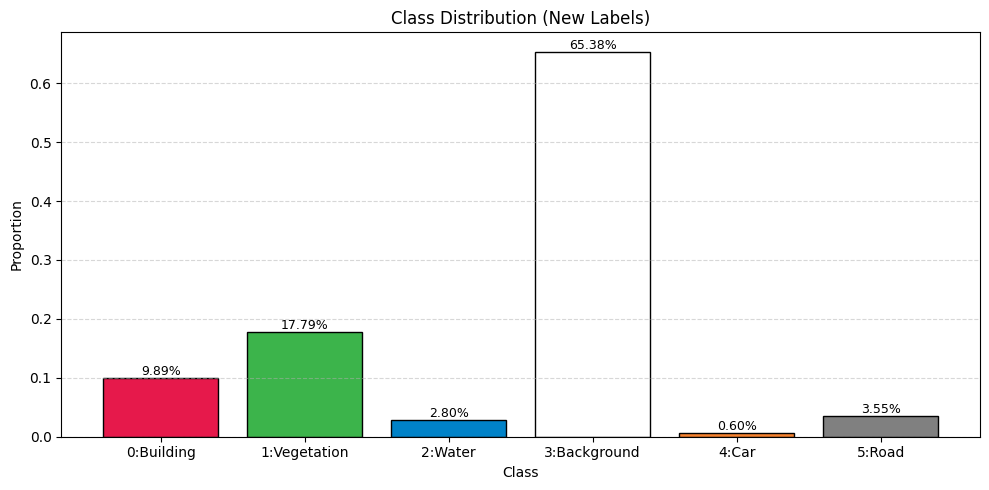

In [ ]:
df_full = csv_to_full_df()
plot_class_distribution_from_df(df_full, "Class Distribution (New Labels)")

Unique colors in label: {(np.uint8(245), np.uint8(130), np.uint8(48)), (np.uint8(230), np.uint8(25), np.uint8(75)), (np.uint8(255), np.uint8(255), np.uint8(255)), (np.uint8(60), np.uint8(180), np.uint8(75)), (np.uint8(128), np.uint8(128), np.uint8(128))}


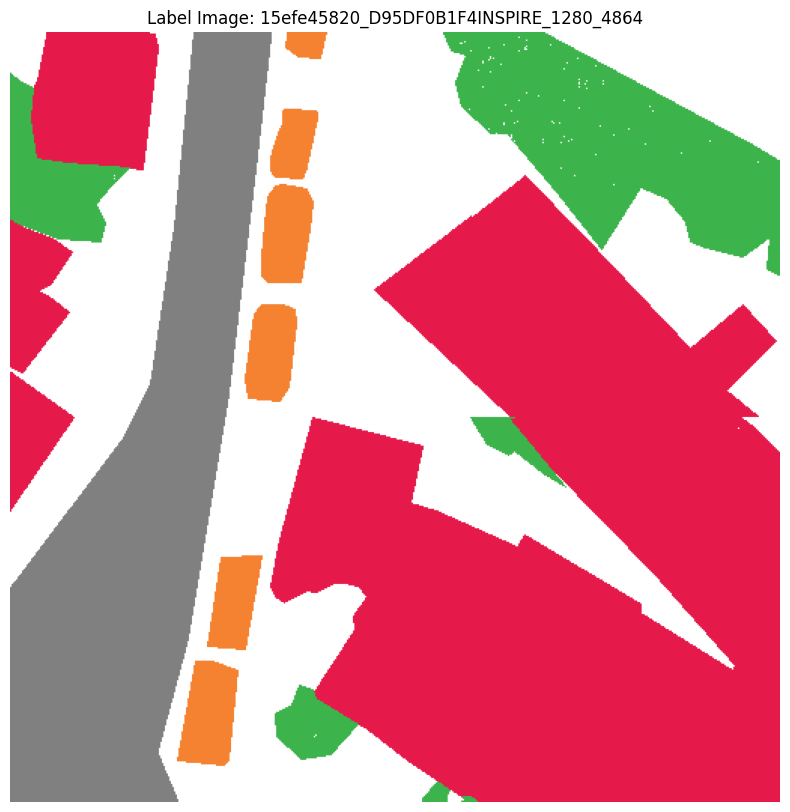

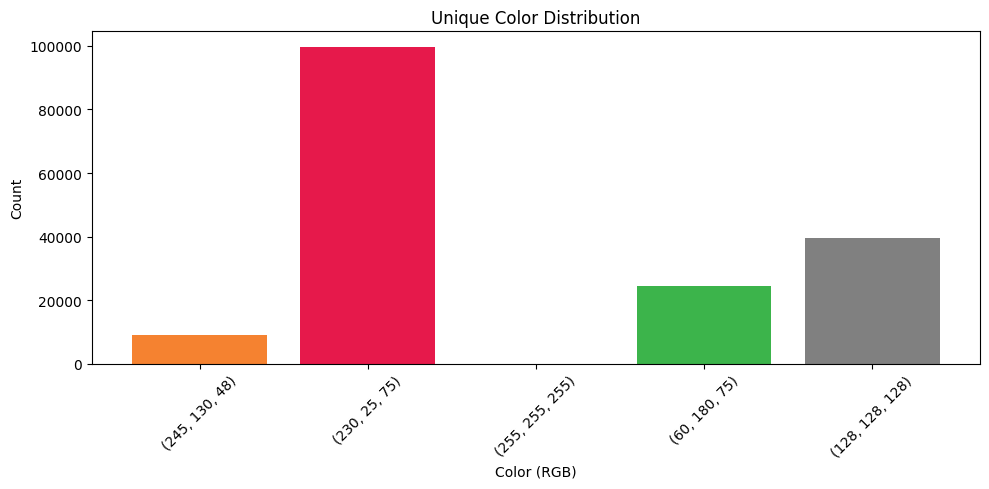

In [ ]:
import cv2
import os
import matplotlib.pyplot as plt

# Path to the label image
label_path = '/content/chipped_data/chipped_data/train/labels/15efe45820_D95DF0B1F4INSPIRE_1280_4864-label.png'
label = cv2.imread(label_path)

if label is None:
    print(f"Error: Could not load image from {label_path}")
else:
    # Convert from BGR (OpenCV default) to RGB for correct color display
    label_rgb = cv2.cvtColor(label, cv2.COLOR_BGR2RGB)
    unique_colors = [tuple(c) for c in label_rgb.reshape(-1, 3)]
    print("Unique colors in label:", set(unique_colors))

    # Plot the label image
    plt.figure(figsize=(10, 10))
    plt.imshow(label_rgb)
    plt.title('Label Image: 15efe45820_D95DF0B1F4INSPIRE_1280_4864')
    plt.axis('off')  # Hide axes
    plt.show()

    # Optional: Plot a bar chart of unique color counts
    color_counts = {color: unique_colors.count(color) for color in set(unique_colors)}
    colors = list(color_counts.keys())
    counts = list(color_counts.values())

    plt.figure(figsize=(10, 5))
    plt.bar(range(len(colors)), counts, color=[list(c/255 for c in color) for color in colors]) # Normalize colors to 0-1 range
    plt.title('Unique Color Distribution')
    plt.xlabel('Color (RGB)')
    plt.ylabel('Count')
    plt.xticks(range(len(colors)), [f'({r}, {g}, {b})' for r, g, b in colors], rotation=45)
    plt.tight_layout()
    plt.show()